In [1]:
#import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mapboxgl.viz import *
from mapboxgl.utils import *
from scipy.cluster.vq import kmeans2, whiten
from coloraide import Color

# Load Data Set
year  = "2021"
month = "10"
URL = f"https://data.urbansharing.com/oslobysykkel.no/trips/v1/{year}/{month}.csv"
o_df = pd.read_csv(URL)


#Matbox token
token = "pk.eyJ1IjoibWFwYm94IiwiYSI6ImNpejY4NXVycTA2emYycXBndHRqcmZ3N3gifQ.rJcFIG214AriISLbB6B5aw"
o_df.head()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2021-10-01 03:03:09.586000+00:00,2021-10-01 03:08:19.084000+00:00,309,397,Storo Storsenter,langs Vitaminveien,59.946710,10.773805,393,Hans Nielsen Hauges plass,langs Hans Nielsen Hauges gate,59.939244,10.774319
1,2021-10-01 03:03:42.698000+00:00,2021-10-01 03:12:51.917000+00:00,549,583,Galgeberg,langs St. Halvards gate,59.907076,10.779164,585,Nordre gate,ved Grünerbrua,59.921150,10.754714
2,2021-10-01 03:07:18.929000+00:00,2021-10-01 03:16:44.444000+00:00,565,514,Sofienberggata,ved Sars gate,59.921206,10.769989,442,Vulkan,ved Maridalsveien,59.922510,10.751010
3,2021-10-01 03:07:43.339000+00:00,2021-10-01 03:18:25.719000+00:00,642,444,AHO,langs Maridalsveien,59.925265,10.750462,558,Dokkveien,ved Støperigata,59.910974,10.727700
4,2021-10-01 03:08:45.961000+00:00,2021-10-01 03:18:15.293000+00:00,569,446,Bislett Stadion,ved rundkjøringen,59.925471,10.731219,478,Jernbanetorget,Europarådets plass,59.911901,10.749929


In [2]:


#Converting dates to datetime
o_df["started_at"]= pd.to_datetime(o_df["started_at"]) 
o_df["ended_at"]= pd.to_datetime(o_df["ended_at"])
o_df['Ukedag'] = o_df['started_at'].dt.day_name()



In [3]:
#A class to keep station data
class station:
    def __init__(self, id,longitude,latitude,name, change = 0, zone = 0):
        self.id = id
        self.long = longitude
        self.lat = latitude
        self.name = name
        self.change = change
        self.zone = zone
    
    def updateChange(self, tick):
        self.change += tick
    def setZone(self, zone):
        self.zone = zone
    def getZone(self):
        return self.zone        
    def getId(self):
        return self.id
    def getName(self):
        return self.name
    def getLongLat(self):
        return [self.long,self.lat]
    def getChange(self):
        return self.change
    def export(self):
        return [self.id,self.name,self.long,self.lat,self.change,self.zone]

In [4]:


#Getting only uniqe station ID's
o_df = o_df.sort_values('start_station_id', ascending=False)
sdf = o_df.drop_duplicates(subset='start_station_name', keep='first')
sdf = sdf.sort_values('start_station_id', ascending=True)
sdf.head()



,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude,Ukedag
2987,2021-10-01 21:59:25.328000+00:00,2021-10-01 22:10:59.056000+00:00,693,377,Tøyenparken,ved Caltexløkka,59.915667,10.777567,421,Alexander Kiellands Plass,langs Maridalsveien,59.928067,10.751203,Friday
32536,2021-10-08 14:17:19.476000+00:00,2021-10-08 14:33:15.032000+00:00,955,378,Colosseum Kino,langs Fridtjof Nansens vei,59.929843,10.711285,607,Marcus Thranes gate,ved Akerselva,59.932772,10.758595,Friday
39599,2021-10-10 15:03:57.231000+00:00,2021-10-10 15:17:46.733000+00:00,829,380,Bentsebrugata,rett over busstoppet,59.939230,10.759170,609,Fred Olsens gate,ved Karl Johans gate,59.911051,10.749374,Sunday
20984,2021-10-06 10:52:42.753000+00:00,2021-10-06 11:01:36.835000+00:00,534,381,Grønlands torg,ved Tøyenbekken,59.912520,10.762240,1755,Aker Brygge,ved trikkestopp,59.911184,10.730035,Wednesday
15312,2021-10-05 10:24:41.679000+00:00,2021-10-05 10:26:47.426000+00:00,125,382,Stensgata,ved trikkestoppet,59.929586,10.732839,446,Bislett Stadion,ved rundkjøringen,59.925471,10.731219,Tuesday


In [5]:


#Assign each station to it¨s own station object
listOfStations=[]
for index, row in sdf.iterrows():
                  #id,latitude,longitude
    tmp = station(row[3],row[6],row[7],row[4])
    listOfStations.append(tmp)



D:\Programering\Anaconda\envs\dave3625\lib\site-packages\scipy\cluster\vq.py:607: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


Text(0, 0.5, 'Longitude')

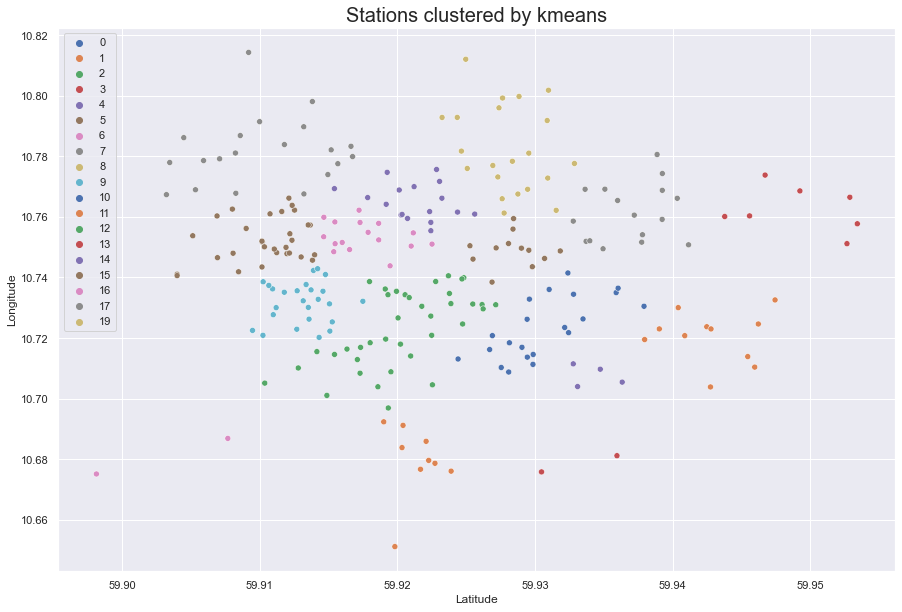

In [6]:
#Devide the stations to zones, based on kmeans2
zones = 20
cor = []
for station in listOfStations:
    cor.append(station.getLongLat())
coordinates= np.array(cor)
x, y = kmeans2(whiten(coordinates), zones, iter = 150)  
#y is the var with zones

#Plot the zones
sns.set(rc={'figure.figsize':(15,10)})
sns.scatterplot(data=coordinates, x=coordinates[:,0], y=coordinates[:,1], hue=y, palette="deep")
plt.title("Stations clustered by kmeans", fontsize=20)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Longitude', fontsize=12)

In [7]:


#Add zones to station object
for i in range(len(listOfStations)):
    listOfStations[i].setZone(y[i]+1)



In [8]:


# Create a new df to easier convert it to geojson
newDf = pd.DataFrame(columns = ["Id", "Name", "Longitude", "Latitude", "Change", "Zone"])



In [9]:


#Fill newDf with data
for s in listOfStations:
    series = pd.Series(s.export(), index = newDf.columns)

    newDf = newDf.append(series, ignore_index=True)



In [10]:


#Create a geojson object for mapbox plot
df_to_geojson(newDf, filename='points.geojson',
              properties=['Id', 'Name','Change','Zone'],
              lon='Latitude', lat='Longitude', precision=3)



{'type': 'file', 'filename': 'points.geojson', 'feature_count': 251}

In [11]:


#For html version
#geoFile = "https://raw.githubusercontent.com/anafvana/DAVE3625_FinalProject/master/points.geojson"
#For local usage:
geoFile ='points.geojson'



In [12]:
nrZones = y.max()+1
color_stops = Color("red").steps(["yellow", "purple","green", "blue" ], steps=nrZones)
c = ([x.to_string() for x in color_stops])
l = []
for i in range(nrZones):
    c[i]=c[i].replace(" ", ",")
    l.append([i+1,c[i]])

    

In [14]:
#Plot clustered zones on the map
center =(10.77837,59.928349)
zoom = 10
#color_breaks = [num for num in range(0,zones)]
# Generate data breaks and color stops from colorBrewer
#color_breaks = [1,2,3,4,5,6,7,8,9,10,11,12]
#color_stops = create_color_stops(color_breaks, colors="Set3")
#color_stops2 = Color("red").steps(["yellow",'green','purple', "blue"], steps=zones)
# Create the viz from the dataframe
#from IPython.display import IFrame
viz = CircleViz(geoFile,
                access_token=token,
                height='500px',
                radius=3,
                color_property = "Zone",
                color_stops = l,
                center = center,
                zoom = zoom,
                below_layer = 'waterway-label'
              )
viz.show(True)
#display(IFrame(viz.show(), width=900, height=650))

D:\Programering\Anaconda\envs\dave3625\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
